## <a id='top'></a>

# CSCI 3202, Fall 2020
# Assignment 2
# Due: Friday 25 September 2020 by 11:59 PM

<br> 

### Your name: Jeremy M. Hein

<br> 

## Problem 1 (15 points)

Consider the directed state space graph below.

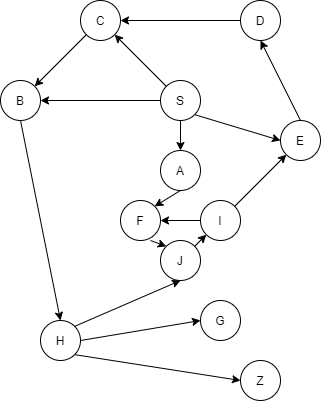

Suppose we wish to find the shortest edge-length path from the start node `S` to the goal node `G`.  Additionally, we have access to the heuristic of "straight line distance from the given node to `G`."


For each of the following search algorithms, what is the full route chosen from `S` to `G`?  For any algorithms that require an order by which to choose/queue equivalent nodes, assume that we open nodes alphabetically.

#### 1a) Breadth-First Search

Explored: {S} Frontier: {A, B, C, E}

Explored: {S, A} Frontier: {B, C, E, F}

Explored: {S, A, B} Frontier: {C, E, F, H}

Explored: {S, A, B, C} Frontier: {E, F, H}

Explored: {S, A, B, C, E} Frontier: {F, H, D}

Explored: {S, A, B, C, E, F} Frontier: {H, D, J}

Explored: {S, A, B, C, E, F, H} Frontier: {D, J, G}


Final Path: S -> B -> H -> G

#### 1b) Depth-First Search

Explored: {S} Frontier: {A, B, C, E}

Explored: {S, A} Frontier: {B, C, E, F}

Explored: {S, A, F} Frontier: {B, C, E, J}

Explored: {S, A, F, J} Frontier: {B, C, E, I}

Explored: {S, A, F, J, I} Frontier: {B, C, E}

Explored: {S, A, F, J, I, E} Frontier: {B, C, D}

Explored: {S, A, F, J, I, E, D} Frontier: {B, C}

Explored: {S, A, F, J, I, E, D, C} Frontier: {B}

Explored: {S, A, F, J, I, E, D, C, B} Frontier: {H}

Explored: {S, A, F, J, I, E, D, C, B, H} Frontier: {G, Z}

Final Path: S -> A -> F -> J -> I -> E -> D -> C -> B -> H -> G

#### 1c) Greedy Best-First, with straight-line-distance heuristic


Current: {S} Frontier: {A, B, C, E}

Current: {A} Frontier: {F}

Current: {F} Frontier: {J}

Current: {J} Frontier: {I}

Current: {I} Frontier: {F,E}

Current: {F} Frontier: {J}

Current: {J} Frontier: {I}

Current: {I} Frontier: {F,E}

Current: {F} Frontier: {J}
.
.
.

Our Greedy Best-First algorithm doesn't maintain an active memory of where it's been.  It only considers the nodes immediately next to it's current state, and chooses the one based on the heuristic.  In this case, it will choose A -> F -> J as those are the closest to the end goal.  However since, this is a directional graph, it will keep repeating the cycle from J-> I-> F-> J because it will never choose the path I -> E, as E is further away from the goal state than F.  So it will never find a solution path.

#### 1d) A$^*$, with straight-line-distance heuristic


It would end with the optimal path S->B->H->G

#### 1e) Describe what properties of this graph may or may not have led to different paths from the algorithms above.

The graph is directional, which led to non-optimal paths for two of our four algorithms.  This acted as an obstacle for all of the algorithms that chose to go to node A with it's first move.  In particular, it led the Greedy algorithm to get stuck in a loop.  For the Greedy and the A* algorithms, the choice to go to node A first is due to how we defined the heuristic.  In the case of DFS, it is because we prioritized nodes in alphabetical order.  While A* does find the optimal route, it still expands the nodes A, F, J, I, and (likely) E, before looking at the route S->B.



## Problem 2 (30 points)

### Escape from Chicago

It is the year 2030 and a freak earthquake has caused Chicago to break off from the mainland of Illinois. It has drifted out into Lake Michigan and is now used as a penal colony for the United States' worst criminals.  Snake Plisskin, world-famous tough guy and amateur sea lion enthusiast, must travel from Chicago to New York to find the antidote to the *Plutoxin 7 poison* that he and many other Chicagoans have been infected with.

Below are crude graphs, representing the northeastern United States.  The graph on the left, **map_distances**, represents the step costs between two states on the graph (cities) using the distance between the two cities along major highways.  On the right, **map_times** represents the step costs using estimated travel time (at 5 PM on a Friday, east coast time).  These graphs are defined in the helper routines at below.

If you take a look at those graphs, you will notice that for brevity's sake, we will use **lowercase** abbreviations for each city, consisting of the **first 3 letters** of the city's name.  So Providence is represented by the state 'pro', for example.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats

**map_distances**          |  **map_times**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 550px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1rI5w8CuWOS9reMIewc2IDBp_Z3pSUu1H" alt="Drawing" style="width: 550px;"/>

### Useful helper routines for searching

In [2]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [3]:
map_distances = dict(
    chi=dict(det=283, cle=345, ind=182),
    cle=dict(chi=345, det=169, col=144, pit=134, buf=189),
    ind=dict(chi=182, col=176),
    col=dict(ind=176, cle=144, pit=185),
    det=dict(chi=283, cle=169, buf=256),
    buf=dict(det=256, cle=189, pit=215, syr=150),
    pit=dict(col=185, cle=134, buf=215, phi=305, bal=247),
    syr=dict(buf=150, phi=253, new=254, bos=312),
    bal=dict(phi=101, pit=247),
    phi=dict(pit=305, bal=101, syr=253, new=97),
    new=dict(syr=254, phi=97, bos=215, pro=181),
    pro=dict(bos=50, new=181),
    bos=dict(pro=50, new=215, syr=312, por=107),
    por=dict(bos=107))

map_times = dict(
    chi=dict(det=280, cle=345, ind=200),
    cle=dict(chi=345, det=170, col=155, pit=145, buf=185),
    ind=dict(chi=200, col=175),
    col=dict(ind=175, cle=155, pit=185),
    det=dict(chi=280, cle=170, buf=270),
    buf=dict(det=270, cle=185, pit=215, syr=145),
    pit=dict(col=185, cle=145, buf=215, phi=305, bal=255),
    syr=dict(buf=145, phi=245, new=260, bos=290),
    bal=dict(phi=145, pit=255),
    phi=dict(pit=305, bal=145, syr=245, new=150),
    new=dict(syr=260, phi=150, bos=270, pro=260),
    pro=dict(bos=90, new=260),
    bos=dict(pro=90, new=270, syr=290, por=120),
    por=dict(bos=120))

sld_providence = dict(
    chi=833,
    cle=531,
    ind=782,
    col=618,
    det=596,
    buf=385,
    pit=458,
    syr=253,
    bal=325,
    phi=236,
    new=157,
    pro=0,
    bos=38,
    por=136)

def check_map(step_costs):
    ''' function to check if all the path costs are at least symmetric '''
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

<a id='p1a'></a>
### (2a)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using breadth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `map_distances`) along the list of states **path**

In [94]:
def breadth_first(start, goal, state_graph, return_cost):
    
    #dictionary for explored states
    explored = {start : None}
    
    #dictionary for frontier
    frontier = {}
    
    #populate frontier dict with key:start, where start is the path it took to get to key
    for key in state_graph[start].keys():
        frontier[key] = start
    
    #queue to be explored in alphabetical order
    queue = sorted(frontier.keys())
    
    #set previous state to start
    previous = start
    
    while goal not in frontier.keys():
        #get the next move from the queue
        next_move = queue[0]
        
        #add to explored and remove from queue and frontier
        explored[next_move] = frontier[next_move]
        queue.pop(0)
        del(frontier[next_move])
        
        #check for any duplicates, and add non duplicates to frontier and the queue
        for key, value in sorted(state_graph[next_move].items()):
            if key not in explored.keys() and key not in frontier.keys():
                frontier[key] = next_move
            if key not in explored.keys()and key not in queue:
                queue.append(key)

         #reset previous
        previous = next_move
    
    #once goal is in our frontier, we need to update the path
    explored[goal] = previous
    
    #call path and pathcost functions
    finalpath = path(explored, goal)
    
    #return based on input parameters
    if return_cost == True:
        pcost = pathcost(finalpath, state_graph)
        return (finalpath,pcost)
    else:
        return finalpath
    

breadth_first('chi', 'bos', map_distances, True)
#Consistent with solution in lecture

(['chi', 'cle', 'buf', 'syr', 'bos'], 996)

<a id='p1b'></a>
### (2b)

#### Depth-first search

Implement a function **depth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using depth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
    * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
    * If **False**, then the only output is the solution path list object

In [93]:
def depth_first(start, goal, state_graph, return_cost):
    
    #dictionary for explored states
    explored = {start : None}
    
    #dictionary for frontier
    frontier = {}
    
    #populate frontier dict with key:start, where start is the path it took to get to key
    for key in state_graph[start].keys():
        frontier[key] = start
    
    #queue to be explored in alphabetical order
    queue = sorted(frontier.keys())
    
    #set previous state to start
    previous = start
    
    while goal not in frontier.keys():
        #get the next move from the queue 
        next_move = queue[0]
        
        #add to explored and remove from queue and frontier
        explored[next_move] = frontier[next_move]
        queue.pop(0)
        del(frontier[next_move])
        
        #check for any duplicates, and add non duplicates to frontier and the queue
        #also sort keys in REVERSE order since we're adding elements to the front of the list below
        for key, value in sorted(state_graph[next_move].items(), reverse=True):
            
            #Note in DFS: If the key is already in the frontier, we DO want to update the predecessor
            if key not in explored.keys():
                frontier[key] = next_move
                
            #insert at the beginning if this is a new node
            if key not in explored.keys() and key not in queue:
                queue.insert(0, key)
                
            #if node is already in queue, remove and place it at the font of the queue
            elif key not in explored.keys() and key in queue:
                queue.remove(key)
                queue.insert(0,key)

         #reset previous
        previous = next_move
    
    #once goal is in our frontier, we need to update the path
    explored[goal] = previous
    
    #call path and pathcost functions
    finalpath = path(explored, goal)
    
    #return based on input parameters
    if return_cost == True:
        pcost = pathcost(finalpath, state_graph)
        return (finalpath,pcost)
    else:
        return finalpath
    

depth_first('chi', 'bos', map_distances, True)
#consistent with lecture example

(['chi', 'cle', 'buf', 'pit', 'bal', 'phi', 'new', 'bos'], 1409)

<a id='p1c'></a>
### (2c)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the `heapq` package is imported in the helpers at the bottom of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** is the initial state (e.g., **start**='chi')
  * **cost** is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states**: maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q**: a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. I only suggest to code it in this way because I think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [21]:
class Frontier_PQ:
    
    def __init__(self, cost, start):
        self.start = start
        self.cost = cost
        self.states = {}
        self.q = []
        self.previous = {}
        
    def add(self, cost, state, p):
        #add to states dictionary
        self.states[state] = cost
        self.previous[state] = p
        
        #push to the queue
        heapq.heappush(self.q,(cost, state)) 
        
    def pop(self):
        #get the first item in queue
        my_tuple = heapq.heappop(self.q)
        
        p = self.previous[my_tuple[1]]
        
        #delete from self.states
        del(self.states[my_tuple[1]])
        del(self.previous[my_tuple[1]])
        
        l = list(my_tuple)
        l.append(p)
        
        #return the tuple
        return tuple(l)
        
    def replace(self, state, cost, p):
        old = self.states[state]
        self.states[state] = cost
        self.previous[state] = p
        
        self.q.remove((old,state))
        
        heapq.heappush(self.q,(cost, state))
        

In [14]:
## testing class implementation
node = Frontier_PQ('chi', 0)

print(node.states)
print(node.q)

node.add(200, 'det')
node.add(300, 'cle')

print(node.states)
print(node.q)

nex = node.pop()
print(nex)
print(node.states)
print(node.q)

node.replace('cle', 250)
print(node.states)
print(node.q)

{}
[]
{'det': 200, 'cle': 300}
[(200, 'det'), (300, 'cle')]
(200, 'det')
{'cle': 300}
[(300, 'cle')]
{'cle': 250}
[(250, 'cle')]


**Updates to Code:**

Note that I added an additional dictionary "previous" to the Frontier_PQ class implementation above.  This dict tracks the predecessor / successor states and is the dictionary that is ultimately passed to the path() function to trace the final route.  This is consistent with how I implemented BFS and DFS above as well, where my frontier was both the next state and it's previous state.  I could have tracked the path on each iteration of the loop which may have been more memory-efficient, but it was easier for me to think about conceptually with this implementation.

Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **map_distances** or **map_times** below)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [25]:
def uniform_cost(start, goal, state_graph, return_cost):
    
    #dictionary for explored states
    explored = {start : None}
    
    #initilize instance of Frontier_PQ
    my_queue = Frontier_PQ(start, 0)
    
    #loop through state_graph dict and add the nodes to the frontier and queue
    for key, value in state_graph[start].items():
        my_queue.add(value,key,start)
    
    previous = (0,start)
    
    while goal not in explored.keys():
        #get the next move from the queue
        node = my_queue.pop()
        next_move = node[1]
        next_value = node[0]
        p = node[2]
        
        explored[next_move] = p


        for key, value in state_graph[next_move].items():
            new_distance = value + next_value

            if key not in explored.keys() and key not in my_queue.states.keys():
                my_queue.add(new_distance, key, next_move)

            if key in my_queue.states.keys() and new_distance < my_queue.states[key]:
                my_queue.replace(key, new_distance, next_move)

        previous = node
    
    #call path and pathcost functions
    finalpath = path(explored, goal)
    pcost = pathcost(finalpath, state_graph)
    
    #return based on input parameters
    if return_cost == True:
        return (finalpath,pcost)
    else:
        return finalpath

uniform_cost('chi', 'bos', map_distances, True)

(['chi', 'cle', 'buf', 'syr', 'bos'], 996)

<a id='p1d'></a>
### (2d)

In the code cell below, use a few **print** statements to showcase the output of each of your three search algorithms defined above (in **1a**, **1b** and **1c**) to find routes for Snake to travel from Chicago to New York, with path costs defined by the distance between cities.

Then, in the markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path?
* Why does this not surprise you?

In [32]:
bfs = breadth_first('chi', 'new', map_distances, True)
dfs = depth_first('chi', 'new', map_distances, True)
ucs = uniform_cost('chi', 'new', map_distances, True)

print("BFS yields a path of:", bfs[0])
print("BFS path has a distance of:", bfs[1])
print()
print("DFS yields a path of:", dfs[0])
print("DFS path has a distance of:", dfs[1])
print()
print("UCS yields a path of:", ucs[0])
print("UCS path has a distance of:", ucs[1])

BFS yields a path of:  ['chi', 'cle', 'buf', 'syr', 'new']
BFS path has a distance of:  938

DFS yields a path of:  ['chi', 'cle', 'buf', 'pit', 'bal', 'phi', 'new']
DFS path has a distance of:  1194

UCS yields a path of:  ['chi', 'cle', 'pit', 'phi', 'new']
UCS path has a distance of:  881


**Response:**

Uniform-cost search yields the shortest path.  This isn't surprising as it's the only search method of the three implemented above that takes into account edge weights.  BFS and DFS treat each "road" between cities as equal, which obviously isn't true.

<a id='p1e'></a>
### (2e)

The Plutoxin 7 poison (which Snake has been infected with) will cause Snake's central nervous system to implode after exactly 1000 minutes.

Will any of the paths found in **(1d)** get Snake to New York alive?  Show your work! Snake's life hangs in the balance.

In [36]:
bfs_time = pathcost(bfs[0], map_times)
dfs_time = pathcost(dfs[0], map_times)
ucs_time = pathcost(ucs[0], map_times)

print("The BFS path with take", bfs_time, "minutes.")
print()
print("The DFS path with take", dfs_time, "minutes.")
print()
print("The UCS path with take", ucs_time, "minutes.")

The BFS path with take 935 minutes.

The DFS path with take 1295 minutes.

The UCS path with take 945 minutes.


As shown above, both the UCS and the BFS paths will get Sanke to New York alive.  Note that the UCS path takes longer to reach New York. This is because we found the optimal path based on _miles_ traveled, not minutes traveled.  If we were to run UCS based on minutes, it would yield a different path. 

<a id='p1f'></a>
### (2f)

Since time is a factor, Snake ought to optimize his route from Chicago to New York to minimize the total time required. Because Snake is a renaissance man, he knows some pretty slick search algorithms.  But because he's infected with deadly poison, Snake just isn't up to the task of implementing them - his code is full of bugs and he keeps sneezing all over his monitor!  Let's help him out, shall we?

In the code cell below, find the shortest path from Chicago to New York as measured by total time taken, and display the result using a **print** statement

In the markdown cell below the code cell, write a couple of sentences:
* Why did you choose the search algorithm and state space graph that you chose?
* Would the solution path found by the other algorithms (the ones you didn't use in your function call) change if you tried to optimize based on time as opposed to distance (i.e., used **map_times** as opposed to **map_distances**)? Why or why not?
* **Most importantly:**  will Snake get to New York in time to receive the Plutoxin 7 antidote? This answer should be justified by your code output.

In [38]:
ucs_two = uniform_cost('chi', 'new', map_times, True)

print("UCS yields a path of:", ucs_two[0])
print("UCS path has a time of:", ucs_two[1], "minutes")

UCS yields a path of: ['chi', 'cle', 'buf', 'syr', 'new']
UCS path has a time of: 935 minutes


I chose the UCS algorithm because it is the only algorithm that takes into account edge weight (time between cities, in this case).  The other two will find a solution, but it isn't guaranteed to be optimal as they treat each edge as equal.  The UCS algorithm will find the shortest path.  I chose the state space graph "map_times" because we are concerned with how long it will take to get Snake to New York, not how far the route is.

The solutions wouldn't change with BFS or DFS.  This is because the algorithms unfold cities in a (more or less) alphabetical order rather than prioritizing them based on edge weights.  Since both of the state space graphs are the same other than the edge weights, both of these algorithms will have the same path regardless of which map is chosen.

Yes! Snake will get to New York in time.  As mentioned above, he has 1000 minutes to get there and the shortest time path takes 935 minutes.

## Problem 3 (25 points)

Well, it turns out Snake used the right algorithms and lived through his perilous trip to New York City.  He returned to Chicago, where he is living happily among the criminals, sea lions and criminal sea lions  But we want a sequel!

During Snake's time on the east coast, he came to realize that the soothing Atlantic Ocean air does wonders for his nerves. Living in the penal colony of Chicago is just so stressful! So he has decided to pack up and move to Providence, Rhode Island.

Because Snake has traveled across the country already, he has some prior knowledge regarding how far various cities along the way are from his final destination of Providence.  In particular, Snake maps out the **straight-line distance** from major cities to Providence. This information is displayed graphically below, on a tattoo on Kurt Russell's forearm (you can't prove that isn't true), and in the `sld_providence` dictionary in the [helper functions] at the top of this notebook.

Also note that because it doesn't make much sense to add estimated travel times and the straight-line distance, we will only be using the `map_distances` state space graph for this problem.

**map_distances**          |  **sld_providence**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 500px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1a8FNEG7apKkRX7VvpdMgmeYbqeNuOdwz" alt="Drawing" style="width: 500px;"/>


<a id='p1a'></a>
### (3a)

Modify your code for uniform-cost search from Problem 1 so that it provides optionally as output the number of nodes **expanded** in completing the search. 

Include a new optional logical (True/False) argument **return_nexp**, so your function calls to the new uniform cost search will look like: `uniform_cost(start, goal, state_graph, return_cost, return_nexp)`.
* If `return_nexp` is True, then the last output in the output tuple should be the number of nodes expanded.
* If `return_nexp` is False, then the code should behave exactly as it does in problem 2.

Then, verify that your revised codes are working by checking Snake's optimal route from Chicago to New York. Include the number of nodes expanded and the path cost (using `map_distances`).

In [41]:
def uniform_cost(start, goal, state_graph, return_cost, return_nexp):
    
    #dictionary for explored states
    explored = {start : None}
    
    #initilize instance of Frontier_PQ
    my_queue = Frontier_PQ(start, 0)
    
    #loop through state_graph dict and add the nodes to the frontier and queue
    for key, value in state_graph[start].items():
        my_queue.add(value,key,start)
    
    previous = (0,start)
    count = 1
    
    while goal not in explored.keys():
        #get the next move from the queue (note for depth-first )
        node = my_queue.pop()
        next_move = node[1]
        next_value = node[0]
        p = node[2]
        
        count += 1
        explored[next_move] = p


        for key, value in state_graph[next_move].items():
            new_distance = value + next_value

            if key not in explored.keys() and key not in my_queue.states.keys():
                my_queue.add(new_distance, key, next_move)

            if key in my_queue.states.keys() and new_distance < my_queue.states[key]:
                my_queue.replace(key, new_distance, next_move)

        previous = node
    
    #call path and pathcost functions
    finalpath = path(explored, goal)
    pcost = pathcost(finalpath, state_graph)
    
    #return based on input parameters
    if return_cost == True and return_nexp == True:
        return (finalpath,pcost, count)
    elif return_cost == True:
        return (finalpath,pcost)
    elif return_nexp == True:
        return (finalpath,count)
    else:
        return finalpath

ucs_three = uniform_cost('chi', 'new', map_distances, True, True)

print("UCS yields a path of:", ucs_three[0])
print("UCS path has a distance of", ucs_three[1], "miles")
print("UCS expanded", ucs_three[2], "nodes")


UCS yields a path of: ['chi', 'cle', 'pit', 'phi', 'new']
UCS path has a distance of 881 miles
UCS expanded 11 nodes


### (3b)

#### Heuristic function

Define a function to take as an argument the `state` that Snake is in (city on our graphs), and return as output the value of the straight-line distance heuristic, between Snake's `state` and Providence.  Note that your function should be quite short, and amounts to looking up the proper value from the `sld_providence` dictionary defined in the [helper functions](#helper).  Call this function `heuristic_sld_providence`.


In [44]:
def heuristic_sld_providence(state):
    return sld_providence[state]

heuristic_sld_providence('chi')

833

### (3c)

#### Full-blown A\* search

We are finally ready to help Snake use his knowledge of straight-line distances from various cities to Providence to inform his path-finding from Chicago to Providence!

Modify your uniform-cost search codes from **(2a)** even further so that they now perform **A\* search**, using as the heuristic function the straight-line distance to Providence.

Provide `heuristic` as an additional argument, which should just be the function name to call within the A\* code. So your call to the A\* routine should look like:  `astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp)`.  (This kind of modular programming will make it much easier to swap in alternative heuristic functions later, and also helps to facilitate debugging if something goes wrong.)

In [56]:
def astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp):
        #dictionary for explored states
    explored = {start : None}
    
    #initilize instance of Frontier_PQ
    my_queue = Frontier_PQ(start, 0)
    
    #loop through state_graph dict and add the nodes to the frontier and queue
    for key, value in state_graph[start].items():
        n = value + heuristic(key) #f(n) + g(n)
        my_queue.add(n,key,start)
    
    previous = (0 + heuristic(start),start) #f(n) + g(n)
    count = 1
    
    while goal not in explored.keys():
        #get the next move from the queue (note for depth-first )
        print("Queue is:", my_queue.q)
        node = my_queue.pop()
        next_move = node[1]
        next_value = node[0]
        p = node[2]
        
        print("Next move is:", next_move)
        
        count += 1
        explored[next_move] = p


        for key, value in state_graph[next_move].items():
            new_distance = value + heuristic(key)

            if key not in explored.keys() and key not in my_queue.states.keys():
                my_queue.add(new_distance, key, next_move)

            if key in my_queue.states.keys() and new_distance < my_queue.states[key]:
                my_queue.replace(key, new_distance, next_move)

        previous = node
    
    #call path and pathcost functions
    finalpath = path(explored, goal)
    pcost = pathcost(finalpath, state_graph)
    
    #return based on input parameters
    if return_cost == True and return_nexp == True:
        return (finalpath,pcost, count)
    elif return_cost == True:
        return (finalpath,pcost)
    elif return_nexp == True:
        return (finalpath,count)
    else:
        return finalpath

a_star = astar_search('chi', 'pro', map_distances, heuristic_sld_providence ,True, True)
ucs_prov = uniform_cost('chi', 'pro', map_distances, True, True)

print("A-Star yields a path of:", a_star[0])
print("A-Star path has a distance of", a_star[1], "miles")
print("A-Star expanded", a_star[2], "nodes")
print()
print("UCS yields a path of:", ucs_prov[0])
print("UCS path has a distance of", ucs_prov[1], "miles")
print("UCS expanded", ucs_prov[2], "nodes")

Queue is: [(876, 'cle'), (879, 'det'), (964, 'ind')]
Next move is: cle
Queue is: [(574, 'buf'), (592, 'pit'), (765, 'det'), (964, 'ind'), (762, 'col')]
Next move is: buf
Queue is: [(403, 'syr'), (592, 'pit'), (765, 'det'), (964, 'ind'), (762, 'col')]
Next move is: syr
Queue is: [(350, 'bos'), (592, 'pit'), (411, 'new'), (964, 'ind'), (762, 'col'), (765, 'det'), (489, 'phi')]
Next move is: bos
Queue is: [(50, 'pro'), (243, 'por'), (372, 'new'), (592, 'pit'), (765, 'det'), (489, 'phi'), (964, 'ind'), (762, 'col')]
Next move is: pro
A-Star yields a path of: ['chi', 'cle', 'buf', 'syr', 'bos', 'pro']
A-Star path has a distance of 1046 miles
A-Star expanded 6 nodes

UCS yields a path of: ['chi', 'cle', 'buf', 'syr', 'bos', 'pro']
UCS path has a distance of 1046 miles
UCS expanded 13 nodes


### (3d)

Snake has already made it to Buffalo on his own, but he is growing weary.  There were ***so*** many sea lions along the way, and he had to stop and admire their grace and beauty.  Use your A\* search code from **(3c)** to help Snake find the optimal path **by distance traveled** the rest of the way to Providence.  Print to the screen the following:
1. the optimal path
2. the optimal path cost (miles traveled)
3. the number of states expanded during the A\* search

Additionally, show below how many states must be expanded to find the optimal path from Buffalo to Providence using the regular old uniform-cost search algorithm from **(3a)**.  Comment on the difference in states that must be explored by each algorithm.

**Sanity check:** No matter what your `start` and `goal` states are, how should the output from `astar_search` and `uniform_cost` search compare?

In [54]:
astar_buf = astar_search('buf', 'pro', map_distances, heuristic_sld_providence ,True, True)
ucs_buf = uniform_cost('buf', 'pro', map_distances, True, True)

print("A-Star yields a path of:", astar_buf[0])
print("A-Star path has a distance of", astar_buf[1], "miles")
print("A-Star expanded", astar_buf[2], "nodes")
print()
print("UCS yields a path of:", ucs_buf[0])
print("UCS path has a distance of", ucs_buf[1], "miles")
print("UCS expanded", ucs_buf[2], "nodes")

Queue is: [(403, 'syr'), (673, 'pit'), (720, 'cle'), (852, 'det')]
Next move is: syr
Queue is: [(350, 'bos'), (489, 'phi'), (411, 'new'), (852, 'det'), (673, 'pit'), (720, 'cle')]
Next move is: bos
Queue is: [(50, 'pro'), (489, 'phi'), (243, 'por'), (673, 'pit'), (720, 'cle'), (852, 'det'), (372, 'new')]
Next move is: pro
A-Star yields a path of: ['buf', 'syr', 'bos', 'pro']
A-Star path has a distance of 512 miles
A-Star expanded 4 nodes

UCS yields a path of: ['buf', 'syr', 'bos', 'pro']
UCS path has a distance of 512 miles
UCS expanded 12 nodes


The optimal path from Buffalo to Providence is buf -> syr -> bos -> pro, and it has a distance of 512 miles.  The A-Star search expanded those four nodes, which is what we expect assuming our heuristic is consistent (which it is, in this case).  UCS, on the other hand, found the same path but it had to expand 12 nodes to get there.  This is because UCS will expand every possible node within that radius in order to find the optimal path.  That's nearly the entire graph, in this case, even though many of the nodes it explored are in the opposite direction of the goal.  The key takeaway here is that A-Star will find the optimal path in a significantly more efficient manner as compared to UCS _as long as the heuristic is consistent._


## Problem 4 (30 points)

Consider this maze, where gray tiles represent walls and orange tiles represent open space where you can walk.

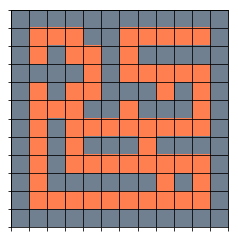

We can represent this maze using a binary `numpy` array as follows, where 1s represent walls and 0s represent open space:

In [133]:
maze = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
                 [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

**Very importantly**, note that the *first* row of the **maze** array corresponds to the *bottom* row of tiles in the figure.  This is a choice made carefully to reflect the fact that we are going to search for a solution path through this maze in *physical* space, so it is useful for our coordinate system to match Cartesian coordinates. This is in contrast to using the first row of the **maze** array to represent the top of the maze, which looks intuitive.

<a id='p3a'></a>
### (4a)

Write a function **maze_to_graph(maze)** that:
* takes as input a binary maze **maze**, stored as a `numpy` array, where 0 represents an open path and 1 represents a wall
* returns a graph dictionary in a similar style to **map_distances** and **map_times** (from Problem 1)
  * the keys are tuples giving the states (coordinate pairs) within the maze (e.g., (1,1) represents the lower-left open space, (2,1) represents the space **to the right** of (1,1), and (0,0) represents the lower-left corner, a wall location); thus, the coordinates within the maze are like Cartesian coordinates, and the x- and y-axes are the bottom and left walls of the maze, respectively
  * the values are themselves dictionaries, where the keys are other states within the maze and the values are the actions taken to move to that state
  * the actions are moves from the list ['N','S','E','W']

In [87]:
def maze_to_graph(maze):
    graph = {}
    length = len(maze)
    for i in range (length):
        for j in range(length):
            if maze[i][j] != 1:
                graph[(j,i)] = {} 
                #moving right
                if maze[i][j+1] != 1:
                    graph[(j, i)][(j+1, i)] = 'E'

                #moving left
                if maze[i][j-1] != 1:
                    graph[(j, i)][(j-1, i)] = 'W'

                #moving down
                if maze[i-1][j] != 1:
                    graph[(j, i)][(j,i-1)] = 'S'

                #moving up
                if maze[i+1][j] != 1:
                    graph[(j, i)][(j,i+1)] = 'N'
                
                
    return graph

my_maze = maze_to_graph(maze)

<a id='p3b'></a>
### (4b)

Use your **maze_to_graph** function and **depth-first search** to solve the maze defined above.  A simple 'print' statement of the path your codes find and its length suffices.
* The initial state is (1,1)
* The goal state is (10,10)

Then, use your **breadth-first search** function to solve the maze; provide the solution path and its length.

If your codes are sufficiently general, the output from **maze_to_graph** should be suitable to be fed straight into your search routines.

In [113]:
def mazecost(path):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += 1
    return cost

bfs_maze = breadth_first((1,1), (10,10), my_maze, False)
bfs_maze_length = mazecost(bfs_maze)

dfs_maze = depth_first((1,1), (10,10), my_maze, False)
dfs_maze_length = mazecost(dfs_maze)

print ("BFS path is:", bfs_maze)
print ("BFS num steps is:", bfs_maze_length)
print()
print ("DFS path is:", dfs_maze)
print ("DFS num steps is:", dfs_maze_length)

BFS path is: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)]
BFS num steps is: 28

DFS path is: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (3, 5), (3, 4), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (7, 4), (7, 5), (8, 5), (9, 5), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)]
DFS num steps is: 32


**Notes to Code:**

I'd like to point out that in my implementations of BFS and DFS (although slightly different), my queue is using sorted(state_graph[next_move].items()) to sort the next move in alphabetical order.  This worked well when the keys were strings representing cities (as was the case in the first problem), but in this case, they keys are tuples and thus the algorithm will choose moves based on how the tuples themselves are sorted, _not_ alphabetical for N,S,E,W.  This may lead to a different path as compared to moves chosen alphabetically from N,S,E,W. 

<a id='p3c'></a>
### (4c)

Write a function **plot_maze(maze, path)** that takes as input a binary `numpy` array **maze** (1s represent walls, 0s represent open space) and a solution **path**, and plots the two together.
* **maze**: a maze represented as a binary `numpy` array, as above
* **path**: a solution path found using your search algorithms above. **path** should be consistent with the output from the **path** function below in the helpers (a list of states).  You may find it useful to provide a default of `None` for **path**, so that you can use your function to just plot a maze that you haven't solved yet.

Then, use your **plot_maze** function to plot the maze defined above, along with the solution path found by **depth-first search**.  You may optionally include the breatdh-first solution as well, but make sure it's clear which path was the depth-first path.


<br>

**Potentially useful:** 

[1] In the helpers, you will notice that there are two packages imported:
  * `import matplotlib.pyplot as plt`
  * `from matplotlib import colors`

`pyplot` and `colors` may be potentially useful to you for generating a pretty plot and generating a colormap for your walls/open spaces in the maze, respectively.  You do not need to use them, but I wanted to provide this nudge for folks who maybe have not done much/any plotting in Python before.

[2] Also, [Color Oracle](http://colororacle.org/) is a useful utility for making colorblind-friendly plots. If you ever plan to show another human being a figure that you have generated, this is nice practice. Check it out!

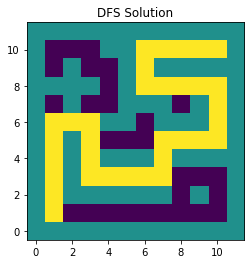

In [137]:
def plot_maze(maze,path, title):
    length = len(maze)
    for i in range (length):
        for j in range(length):
            l =[i,j]
            tupe = tuple(l)
            if tupe in path:
                maze[j][i] = 2
    
    cmap = plt.cm.gray
    plt.imshow(maze,  origin='lower')
    plt.title(title)
    plt.show()
    
plot_maze(maze, dfs_maze, 'DFS Solution')